Candidate number: 44112 


# **P1. CIFAR10 CNN**

Implement a CNN architecture that consists of 3 convolutional layers followed by a fully connected layer of 1000 units.

Each convolutional layer consists of a sublayer of 5x5 convolutional filters with stride 1 followed by a sublayer of 2x2 max-pool units with stride 2. Each neuron applies ReLU activation function.

Task: Evaluate and plot the average training loss per epoch versus the number of epoches for the training dataset, for the following optimization algorithms:

1. Mini-batch gradient descent
2. Mini-batch AdaGrad
3. Mini-batch RMSProp
4. Mini-batch gradient descent with Nesterov’s momentum
5. Mini-batch Adam

In addition, show the results by adding dropout. Comment the results.

In [1]:
# libraries:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
import numpy as np
import matplotlib.pyplot as plt

###1. Data Loading & Preprocessing:

In [2]:
# loading the data:
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# normalizing the images on the range [0,1] for stability:
data_train = data_train.astype('float32') / 255.0
data_test = data_test.astype('float32') / 255.0

# checking the data structure:
print(data_train.shape)
print(data_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
# converting labels to one-hot encoding format for multiclass classification:
num_classes = 10 # CIFAR-10 dataset has 10 distinct image classes
label_train = keras.utils.to_categorical(label_train, num_classes)
label_test = keras.utils.to_categorical(label_test, num_classes)

###2. Training Hyperparameters:

In [4]:
batch_size = 128 # number of images in each mini-batch
epochs = 100 # number of times the dataset is used for training
learning_rate = 0.001 # learning rate parameter for optimizer

# dictionary to store loss results
results_no_dropout = {}
results_with_dropout = {}

# defining the different optimizers for comparison:
optimizers = {
    "SGD": SGD,
    "AdaGrad": Adagrad,
    "RMSProp": RMSprop,
    "Nesterov": lambda lr: SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
    "Adam": Adam
}


### 3. CNN Model:

#### 3.1: Training the Model **Without** Dropout:

Training without dropout means that there is a chance the model will learn all patterns, including noise. This can create low training loss but poor generalization on unseen test data.

Each convolutional layer will consist of:

A convolutional sublayer:


*   5x5 kernel size to capture local features
*   Stride = 1 to move one pixel at a time, ensuring maximum detail
*   ReLu for the activation function
*   Padding = 'same' to preserve input size


A max-pooling sublayer:
*   2x2 pooling size to ensure it keeps the strongest features while reducing the image size
*   Stride = 2 to half the spatial dimensions


In [5]:
for opt_name, opt_class in optimizers.items():
    print(f"\nTraining without Dropout using {opt_name} optimizer...\n")

    # reinitialize optimizer for each model:
    optimizer = opt_class(learning_rate) if opt_name == "Nesterov" else opt_class(learning_rate=learning_rate)

    # CNN model without dropout
    model = Sequential()

    # first convolutional layer:
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # second convolutional layer:
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # third convolutional layer:
    model.add(Conv2D(128, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # flatten feature maps into dense layer:
    model.add(Flatten())

    # fully connected layer with 1,000 neurons:
    model.add(Dense(1000, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))

    # output layer:
    model.add(Dense(10, activation='softmax', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))

    # compile model w/ categorical crossentropy :
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    loss_per_epoch = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}...")

        # shuffle dataset at the start of each epoch
        indices = np.arange(len(data_train))
        np.random.shuffle(indices)
        data_train_shuffled = data_train[indices]
        label_train_shuffled = label_train[indices]

        # select only the first 50 mini-batches:
        batch_subset_size = batch_size * 50
        data_subset = data_train_shuffled[:batch_subset_size]
        label_subset = label_train_shuffled[:batch_subset_size]

        # train on first 50 mini-batches per epoch:
        history = model.fit(data_subset, label_subset, batch_size=batch_size, epochs=1, verbose=1, shuffle=True)

        # store loss:
        avg_loss = np.mean(history.history['loss'])
        loss_per_epoch.append(avg_loss)
        print(f"→ Loss: {avg_loss:.4f}\n")

    results_no_dropout[opt_name] = loss_per_epoch


Training without Dropout using SGD optimizer...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.1413 - loss: 2.6987
→ Loss: 2.5645


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2009 - loss: 2.4537
→ Loss: 2.4427


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2373 - loss: 2.3941
→ Loss: 2.3871


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2510 - loss: 2.3626
→ Loss: 2.3473


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2666 - loss: 2.3241
→ Loss: 2.3182


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2726 - loss: 2.3030
→ Loss: 2.2875


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2816 - loss: 2.2748
→ Loss: 2.2660


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2986 - loss: 2.2416
→ Loss: 2.2354


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3114 - loss: 2.2276
→ Loss: 2.2306


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - ac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1342 - loss: 2.5589
→ Loss: 2.5221


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2109 - loss: 2.4648
→ Loss: 2.4517


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2472 - loss: 2.4120
→ Loss: 2.3984


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2494 - loss: 2.3696
→ Loss: 2.3470


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.2959 - loss: 2.3010
→ Loss: 2.2822


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2914 - loss: 2.2450
→ Loss: 2.2381


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3109 - loss: 2.2179
→ Loss: 2.2032


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3149 - loss: 2.1768
→ Loss: 2.1634


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3390 - loss: 2.1447
→ Loss: 2.1292


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.1694 - loss: 4.3258
→ Loss: 2.9265


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2940 - loss: 2.2587
→ Loss: 2.1692


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3659 - loss: 1.9941
→ Loss: 1.9487


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4328 - loss: 1.7743
→ Loss: 1.7783


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4795 - loss: 1.6815
→ Loss: 1.6674


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5036 - loss: 1.6114
→ Loss: 1.6077


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5282 - loss: 1.5528
→ Loss: 1.5239


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5371 - loss: 1.4973
→ Loss: 1.4758


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5822 - loss: 1.3935
→ Loss: 1.3931


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1536 - loss: 2.5560
→ Loss: 2.4329


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2901 - loss: 2.2310
→ Loss: 2.1944


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3413 - loss: 2.0979
→ Loss: 2.0808


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3641 - loss: 2.0437
→ Loss: 2.0344


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3970 - loss: 1.9614
→ Loss: 1.9645


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4066 - loss: 1.9213
→ Loss: 1.9182


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4133 - loss: 1.8954
→ Loss: 1.8675


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4397 - loss: 1.8492
→ Loss: 1.8400


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4505 - loss: 1.8150
→ Loss: 1.8030


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.1446 - loss: 3.2138
→ Loss: 2.5619


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3589 - loss: 1.9559
→ Loss: 1.8943


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4274 - loss: 1.7355
→ Loss: 1.7203


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4591 - loss: 1.6271
→ Loss: 1.6044


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5037 - loss: 1.5222
→ Loss: 1.5161


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5304 - loss: 1.4800
→ Loss: 1.4377


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5730 - loss: 1.3675
→ Loss: 1.3710


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5803 - loss: 1.3351
→ Loss: 1.3415


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5739 - loss: 1.3307
→ Loss: 1.2968


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━

#### 3.2: Training the Model **With** Dropout:

Dropout is a regularization technique that can prevent overfitting. Adding a dropout term of 0.5 means that it will randomly "drop" 50% of the neurons during training, forcing the model not to rely on specific neurons, which can make it more generalizable.  

*Note: this is the exact same code as previously but with dropout added to the last layer. We add dropout after the ReLU activation function in a fully connected layer to help prevent overfitting and improve generalization ability*

In [6]:
for opt_name, opt_class in optimizers.items():
    print(f"\nTraining WITH Dropout using {opt_name} optimizer...\n")

    optimizer = opt_class(learning_rate) if opt_name == "Nesterov" else opt_class(learning_rate=learning_rate)

    # CNN model with dropout
    model = Sequential()

    # first convolutional layer:
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # second convolutional layer:
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # third convolutional layer:
    model.add(Conv2D(128, (5,5), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2)) # max-pooling sublayer

    # flatten feature maps into dense layer
    model.add(Flatten())

    # fully connected layer with 1,000 neurons:
    model.add(Dense(1000, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))
    # adding dropout (50%):
    model.add(Dropout(0.5))

    # output layer:
    model.add(Dense(10, activation='softmax', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.0001)))

    # compile model w/ categorical crossentropy:
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    loss_per_epoch = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}...")

        # shuffle dataset at the start of each epoch
        indices = np.arange(len(data_train))
        np.random.shuffle(indices)
        data_train_shuffled = data_train[indices]
        label_train_shuffled = label_train[indices]

        # select only first 50 mini-batches:
        batch_subset_size = batch_size * 50
        data_subset = data_train_shuffled[:batch_subset_size]
        label_subset = label_train_shuffled[:batch_subset_size]

        # train on first 50 mini-batches per epoch:
        history = model.fit(data_subset, label_subset, batch_size=batch_size, epochs=1, verbose=1, shuffle=True)

        # store loss:
        avg_loss = np.mean(history.history['loss'])
        loss_per_epoch.append(avg_loss)
        print(f"→ Loss: {avg_loss:.4f}\n")

    results_with_dropout[opt_name] = loss_per_epoch



Training WITH Dropout using SGD optimizer...



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1023 - loss: 2.9516
→ Loss: 2.8326


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1255 - loss: 2.6468
→ Loss: 2.6217


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1393 - loss: 2.5585
→ Loss: 2.5497


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1592 - loss: 2.5185
→ Loss: 2.5047


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1704 - loss: 2.4806
→ Loss: 2.4791


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1920 - loss: 2.4544
→ Loss: 2.4464


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2017 - loss: 2.4273
→ Loss: 2.4240


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2124 - loss: 2.4202
→ Loss: 2.4074


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.2226 - loss: 2.3923
→ Loss: 2.3887


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1201 - loss: 2.7963
→ Loss: 2.6650


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.1779 - loss: 2.5015
→ Loss: 2.4872


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1893 - loss: 2.4383
→ Loss: 2.4258


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2116 - loss: 2.3942
→ Loss: 2.3840


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2418 - loss: 2.3355
→ Loss: 2.3312


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2474 - loss: 2.3069
→ Loss: 2.2977


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2610 - loss: 2.2754
→ Loss: 2.2730


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.2744 - loss: 2.2402
→ Loss: 2.2273


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2937 - loss: 2.2127
→ Loss: 2.2131


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.1711 - loss: 2.8738
→ Loss: 2.5220


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3008 - loss: 2.1668
→ Loss: 2.1341


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3801 - loss: 1.9429
→ Loss: 1.9121


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4298 - loss: 1.8167
→ Loss: 1.8058


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4521 - loss: 1.7516
→ Loss: 1.7380


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4689 - loss: 1.6991
→ Loss: 1.6526


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5043 - loss: 1.6039
→ Loss: 1.5897


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5327 - loss: 1.5235
→ Loss: 1.5398


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5686 - loss: 1.4359
→ Loss: 1.4691


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1094 - loss: 2.7933
→ Loss: 2.6188


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.1926 - loss: 2.4249
→ Loss: 2.3879


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2440 - loss: 2.2850
→ Loss: 2.2563


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.3023 - loss: 2.1794
→ Loss: 2.1801


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3114 - loss: 2.1455
→ Loss: 2.1299


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3402 - loss: 2.0824
→ Loss: 2.0697


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3501 - loss: 2.0378
→ Loss: 2.0342


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3722 - loss: 2.0022
→ Loss: 2.0017


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3815 - loss: 1.9657
→ Loss: 1.9680


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1000)                │       2,049,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │          10,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,634 (8.84 MB)

 Trainable params: 2,317,634 (8.84 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.1762 - loss: 2.6855
→ Loss: 2.3253


Epoch 2/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3677 - loss: 1.9104
→ Loss: 1.8570


Epoch 3/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.4343 - loss: 1.7528
→ Loss: 1.7233


Epoch 4/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.4762 - loss: 1.6117
→ Loss: 1.6095


Epoch 5/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4946 - loss: 1.5595
→ Loss: 1.5459


Epoch 6/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.5398 - loss: 1.4624
→ Loss: 1.4566


Epoch 7/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5688 - loss: 1.3708
→ Loss: 1.3912


Epoch 8/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5696 - loss: 1.3474
→ Loss: 1.3302


Epoch 9/100...
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5941 - loss: 1.3049
→ Loss: 1.2819


Epoch 10/100...
50/50 ━━━━━━━━━━━━━━━━━━━━

### 4. Plots & Comparison

Now we will plot the training loss per epoch versus the number of epochs for the training dataset.

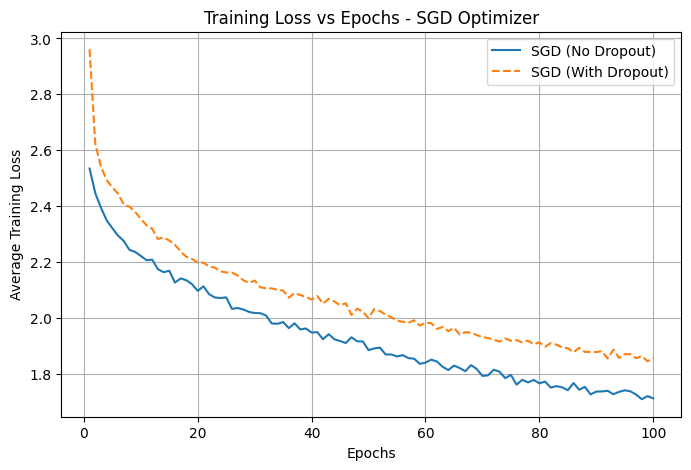

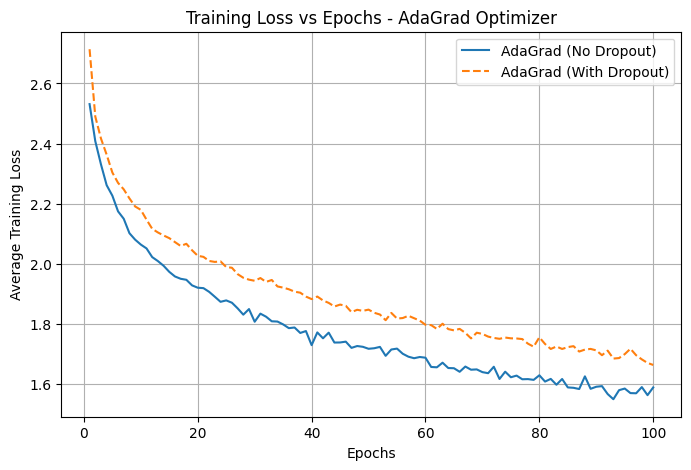

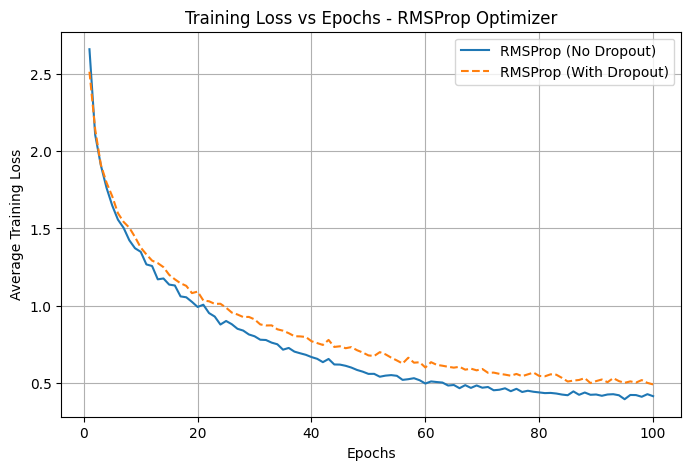

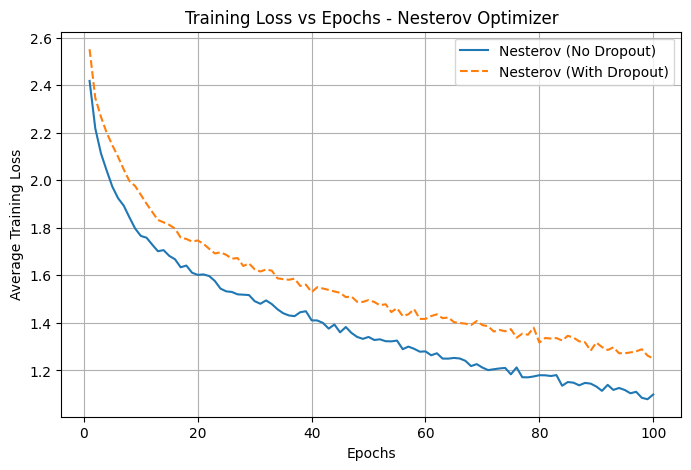

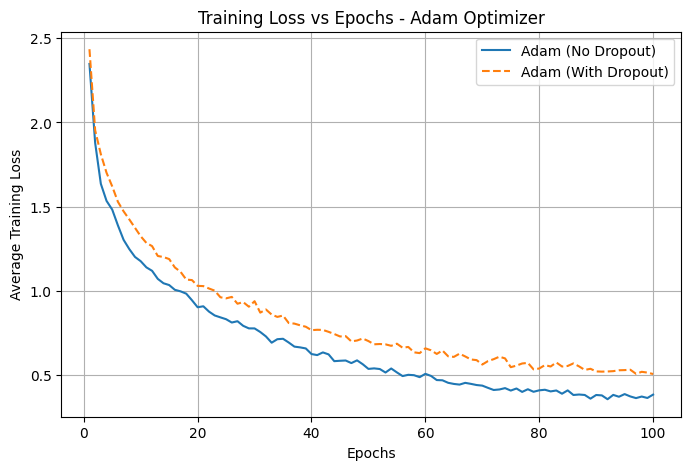

In [ ]:
# loop through each optimizer so each one plots separately:
for opt_name in results_no_dropout.keys():
    plt.figure(figsize=(8,5))

    # training loss without dropout:
    plt.plot(range(1, len(results_no_dropout[opt_name]) + 1),
             results_no_dropout[opt_name],
             label=f"{opt_name} (No Dropout)", linestyle='solid')

    # training loss with dropout:
    if opt_name in results_with_dropout:
        plt.plot(range(1, len(results_with_dropout[opt_name]) + 1),
                 results_with_dropout[opt_name],
                 label=f"{opt_name} (With Dropout)", linestyle='dashed')

    # labels and titles:
    plt.xlabel("Epochs")
    plt.ylabel("Average Training Loss")
    plt.title(f"Training Loss vs Epochs - {opt_name} Optimizer")
    plt.legend()
    plt.grid(True)

    plt.show()

**Analysis**:


*   The model without dropout (solid blue line) has consistently lower training loss. Since there’s no dropout, the network will memorize the training data more effectively. The training loss is lower because the network can rely on all neurons at every step.
*  The model with dropout (dashed orange line) has a slightly higher training loss. Dropout randomly deactivates 50% of neurons in the fully connected layer, forcing the model to be less dependent on specific neurons. As a result, the training loss is higher since the network has to generalize more.

*   The optimizers with the highest discrepancy between dropout and without look to be Nesterov, AdaGrad, and SDG. The optimizers with the smallest discrency is RMSProp.





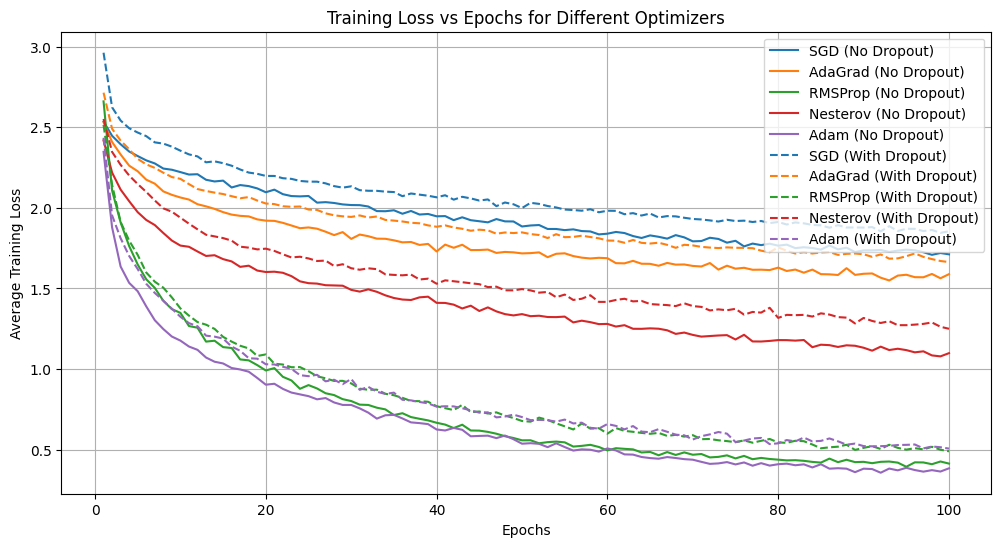

In [ ]:
# all information on one comparison plot:

# make sure the same optimizer has the same color:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
optimizer_list = list(results_no_dropout.keys())  # Get optimizer names
optimizer_colors = {opt_name: default_colors[i % len(default_colors)] for i, opt_name in enumerate(optimizer_list)}

plt.figure(figsize=(12,6))

# training loss for models without dropout:
for i, (opt_name, loss) in enumerate(results_no_dropout.items()):
    color = optimizer_colors[opt_name]  # Get assigned color
    plt.plot(range(1, len(loss) + 1), loss, label=f"{opt_name} (No Dropout)", linestyle='solid', color=color)

# training loss for models with dropout:
for i, (opt_name, loss) in enumerate(results_with_dropout.items()):
    color = optimizer_colors[opt_name]  # Use the same color
    plt.plot(range(1, len(loss) + 1), loss, label=f"{opt_name} (With Dropout)", linestyle='dashed', color=color)

# labels and titles:
plt.xlabel("Epochs")
plt.ylabel("Average Training Loss")
plt.title("Training Loss vs Epochs for Different Optimizers")
plt.legend()
plt.grid(True)

plt.show()


**Analysis:**


*   The Adam and RMSProp curves drop the fastest, reaching lower training loss much earlier. This is because Adam combines momentum and adaptive learning rates, which helps it optimize efficiently.
RMSProp adapts learning rates per parameter, allowing it to stabilize quickly.
*   SGD shows the slowest decline in training loss. The dropout version is consistently higher than the no-dropout version, indicating worse training performance. This might be because SGD doesn't adapt learning rates like Adam or RMSProp, so it takes longer to converge.

*   AdaGrad initially drops well but flattens out after ~40 epochs.
This could be due to the fact that AdaGrad reduces its learning rate too aggressively, which prevents further improvements over time.
*   As mentioned previously, for every optimizer, the dropout version has a higher loss than the no-dropout version. This is expected, as dropout forces the network to generalize more by randomly deactivating neurons.


